# Flux Calculation Test Notebook
This notebook tests momentum, sensible heat, and TKE flux computations
using the **ecflux** package with raw METEK uSonic dataset (27–28 July 2024).

## New API
- `ecflux()`: Unified function for all flux types (H, L, Tau)
- `tke()`: Turbulent kinetic energy calculation


In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
# Import the ecflux package
from ecflux import ecflux, tke


Data loaded: 1727677 records
Time range: 2025-10-17 00:00:00 to 2025-10-17 23:59:59.950000128
Sampling frequency: ~19.996273145991406 Hz


/Users/bhupendra/git_repo/simpleflux/src/ecflux/covariance.py:54: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  flux = df.groupby(pd.Grouper(freq=freq)).apply(compute_window_covariance)
/Users/bhupendra/git_repo/simpleflux/src/ecflux/flux.py:217: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  tau_series = df.groupby(pd.Grouper(freq=freq)).apply(compute_tau_window)


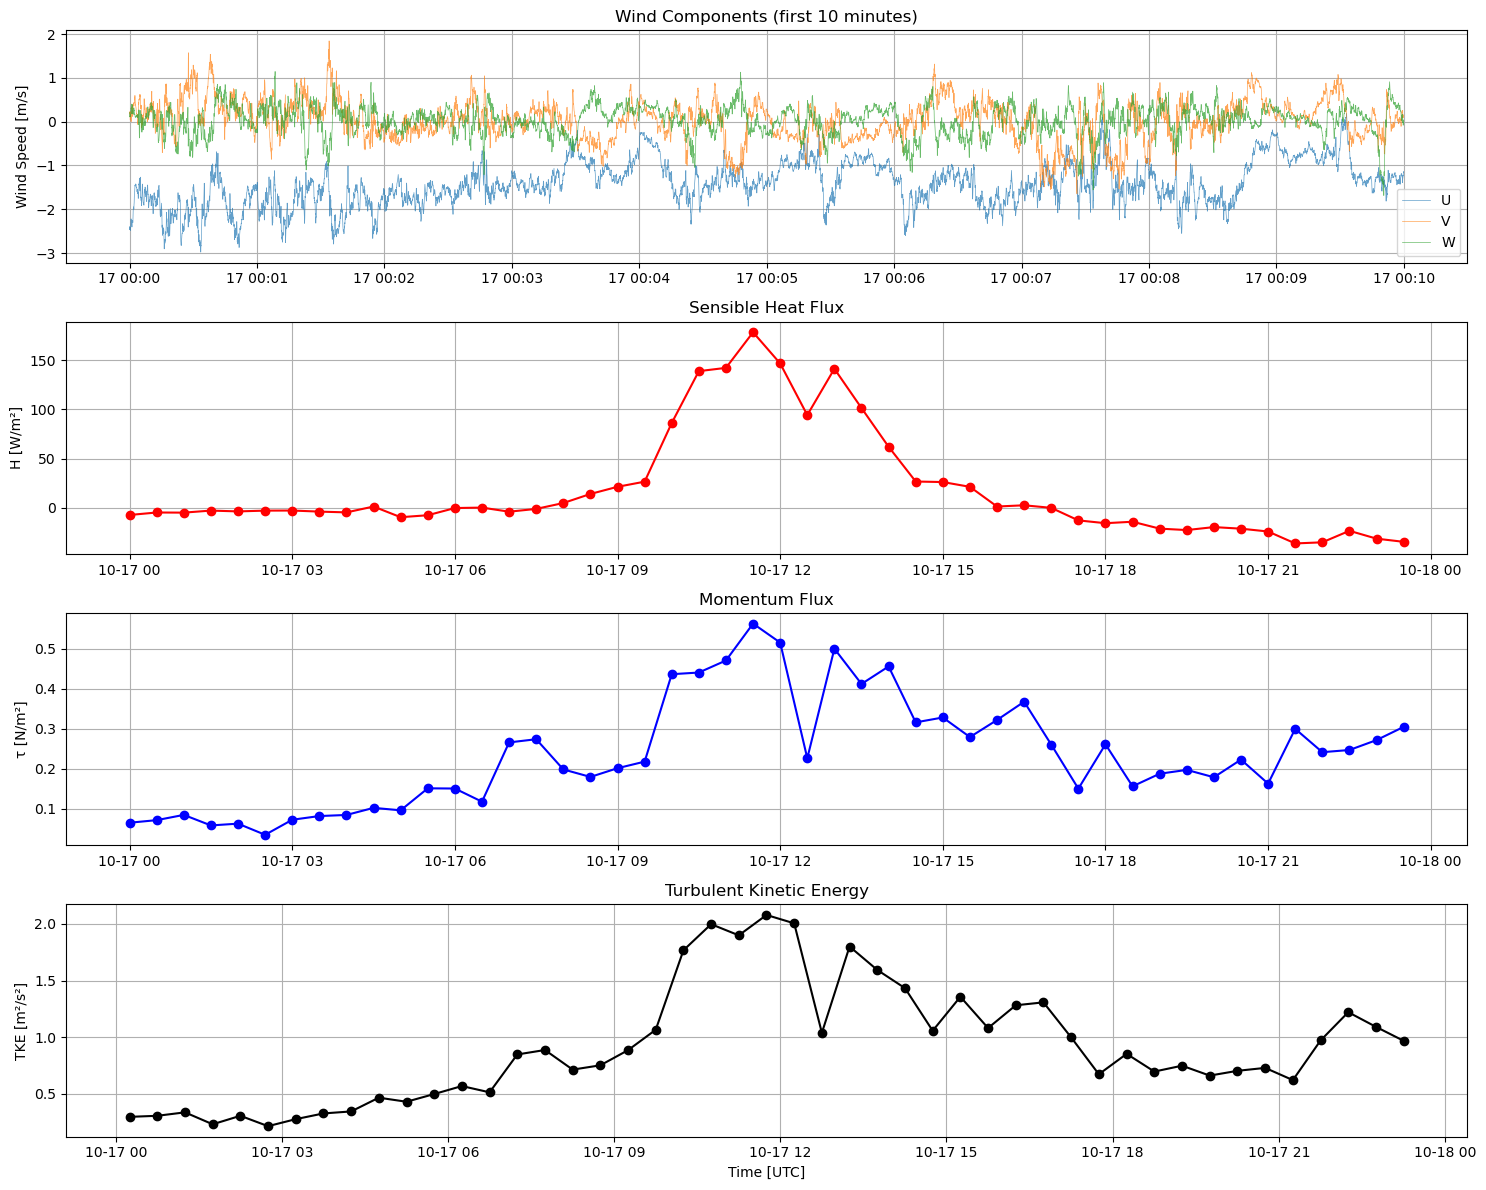


=== Flux Summary ===
Sensible Heat Flux: 17.94 ± 54.47 W/m²
Momentum Flux: 0.2358 ± 0.1368 N/m²
TKE: 0.9134 ± 0.5145 m²/s²


In [3]:
# File path to NetCDF data
nc_path = "/Users/bhupendra/projects/crocus/data/flux_data_uic/data/netcdf/rawnc/202510/crocus-uic-smartflux-raw-20251017T235959.nc"

# ⚙️ Load NetCDF data using xarray
ds = xr.open_dataset(nc_path)

# Extract time and wind/temperature variables
time = pd.to_datetime(ds["time"].values, unit='s', origin='unix')

# Extract wind components and temperature
u = ds["U_m_s"].values
v = ds["V_m_s"].values
w = ds["W_m_s"].values
T = ds["T_C"].values

# Replace fill values (-9999) with NaN
u[u == -9999] = np.nan
v[v == -9999] = np.nan
w[w == -9999] = np.nan
T[T == -9999] = np.nan

# Create DataFrame with datetime index
df = pd.DataFrame({
    "U_m_s": u,
    "V_m_s": v,
    "W_m_s": w,
    "T_C": T
}, index=time).dropna()

print(f"Data loaded: {len(df)} records")
print(f"Time range: {df.index[0]} to {df.index[-1]}")
print(f"Sampling frequency: ~{len(df) / ((df.index[-1] - df.index[0]).total_seconds())} Hz")

# 🧪 Flux calculations using ecflux
# Sampling rate is 20 Hz (from metadata: acquisition_frequency = "20.0")
# For 30-minute windows: window_size = 20 Hz * 1800 s = 36000

# Sensible heat flux (30-minute windows)
H = ecflux(df, w='W_m_s', scalar='T_C', flux='H', freq='30T')

# Momentum flux (30-minute windows)
tau = ecflux(df, w='W_m_s', flux='Tau', freq='30T', u='U_m_s', v='V_m_s')

# TKE (30-minute windows at 20 Hz: 20 * 1800 = 36000 samples)
tke_values, tke_times = tke(df, window_size=36000, u='U_m_s', v='V_m_s', w='W_m_s')

# 📊 Plotting diagnostics
fig, axes = plt.subplots(4, 1, figsize=(15, 12))

# Raw wind components (first 10 minutes for visibility)
sample_df = df.iloc[:12000]  # 20 Hz * 600 s = 12000 samples for 10 min
axes[0].plot(sample_df.index, sample_df['U_m_s'], label='U', alpha=0.7, linewidth=0.5)
axes[0].plot(sample_df.index, sample_df['V_m_s'], label='V', alpha=0.7, linewidth=0.5)
axes[0].plot(sample_df.index, sample_df['W_m_s'], label='W', alpha=0.7, linewidth=0.5)
axes[0].set_title("Wind Components (first 10 minutes)")
axes[0].set_ylabel("Wind Speed [m/s]")
axes[0].legend()
axes[0].grid(True)

# Sensible heat flux
axes[1].plot(H.index, H.values, 'o-', color='red')
axes[1].set_title("Sensible Heat Flux")
axes[1].set_ylabel("H [W/m²]")
axes[1].grid(True)

# Momentum flux
axes[2].plot(tau.index, tau.values, 'o-', color='blue')
axes[2].set_title("Momentum Flux")
axes[2].set_ylabel("τ [N/m²]")
axes[2].grid(True)

# TKE
axes[3].plot(tke_times, tke_values, 'o-', color='black')
axes[3].set_title("Turbulent Kinetic Energy")
axes[3].set_ylabel("TKE [m²/s²]")
axes[3].set_xlabel("Time [UTC]")
axes[3].grid(True)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n=== Flux Summary ===")
print(f"Sensible Heat Flux: {H.mean():.2f} ± {H.std():.2f} W/m²")
print(f"Momentum Flux: {tau.mean():.4f} ± {tau.std():.4f} N/m²")
print(f"TKE: {np.mean(tke_values):.4f} ± {np.std(tke_values):.4f} m²/s²")
